In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

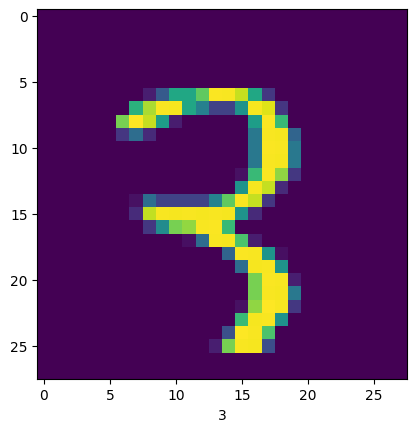

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape

    def apply(self, input_value):
        return np.ndarray.flatten(input_value)

    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)

    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0

    def dummy_gradient(self):
        return 0

    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Scaler:
    def __init__(self, scale_factor):
        self.name = f"Scaler with scale factor {scale_factor}"
        self.param_count = 0

        self.scale_factor = scale_factor

    def apply(self, input_value):
        return self.scale_factor * input_value

    def input_gradient(self, output_gradient, input_value=None, output_value = None):
        return self.scale_factor * output_gradient

    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return 0

    def dummy_gradient(self):
        return 0

    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size

        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)

    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]

    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))

    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))

    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5

    def apply(self, input_value):
        return input_value + self.biases

    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient

    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient

    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))

    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)

    def apply(self, input_value):
        return self.activation_function(input_value)

    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))

    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0

    def dummy_gradient(self):
        return 0

    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need

    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator


    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value

    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)

    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient

    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0

    def dummy_gradient(self):
        return 0

    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size

    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function

    def apply(self, prediction, ground_truth):
        # ground_truth_class = np.argmax(ground_truth)
        # return -np.log(softmax_function(prediction)[ground_truth_class])

        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(softmax_output)))

    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)

    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        -
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0

    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0

    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input

    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient

    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient

    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient, prediction

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss

    def __repr__(self):
        representation = f"{self.name}\n\n"
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation





In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Scaler(scale_factor=(1/255)),
        Flattener(shape=(28,28)),

        Weights(28*28, 400),
        Biases(400),
        ReluActivation(),

        Weights(400, 200),
        Biases(200),
        ReluActivation(),

        Weights(200, 100),
        Biases(100),
        ReluActivation(),

        Weights(100, 10),
        Biases(10),

        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0
losses = []
accuracy = []
# also reset the loss and accuracy, because when model is reinstated training is gone, and so are losses and the accuracy

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Scaler with scale factor 0.00392156862745098
2. Flattener                 : (28, 28) to 784

3. Weights layer             : 784 to 400
4. Biases layer              : 400
5. ReLU Activation

6. Weights layer             : 400 to 200
7. Biases layer              : 200
8. ReLU Activation

9. Weights layer             : 200 to 100
10. Biases layer              : 100
11. ReLU Activation

12. Weights layer             : 100 to 10
13. Biases layer              : 10
14. Softmax Activation, Activated:False

Total parameters = 415310
Loss function = Cross Entropy Loss Function from the logits



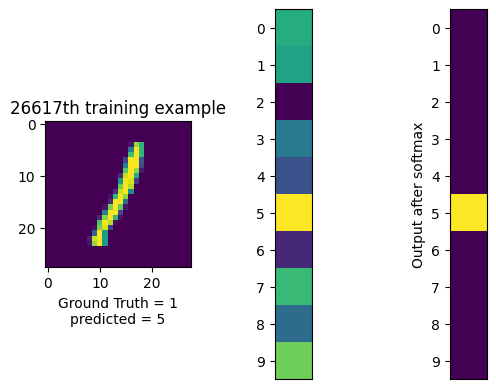

Logits output =  [ 22.23219686  18.62990155 -31.18583661   4.54326479  -9.28433106
  55.15117972 -21.71081261  27.35575637  -0.78513904  36.07966549]
Softmax output =  [5.05204714e-15 1.37724251e-16 3.19381842e-38 1.05017531e-22
 1.03756002e-28 9.99999995e-01 4.16160504e-34 8.48400692e-13
 5.09524915e-25 5.21610836e-09]
Loss value for this example =  -114873.9177036952


In [11]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])

    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 1 =======
Initial Loss = 0
0
Loss after training = 78798.3227002772


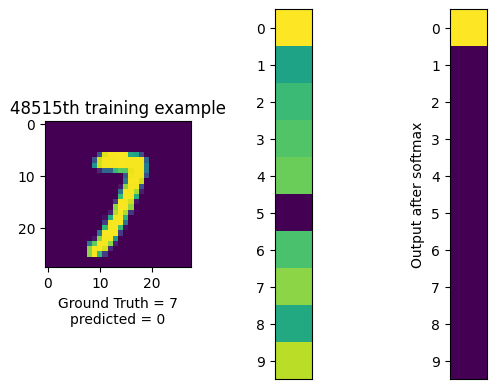

Logits output =  [  84.09240142    4.4122054    23.74013983   32.19031123   41.74963778
 -105.81105334   29.62966873   51.26685523    9.38206945   64.34056152]
Softmax output =  [9.99999997e-01 2.48502379e-35 6.15666924e-27 2.87878104e-23
 4.08104517e-19 3.35720224e-83 2.22400482e-24 5.54685005e-15
 3.57861587e-33 2.64170870e-09]
Loss value for this example =  -150876.87301696814

======= Epoch : 2 =======
Initial Loss = 78798.3227002772
1000
Loss after training = 61183.27817190578


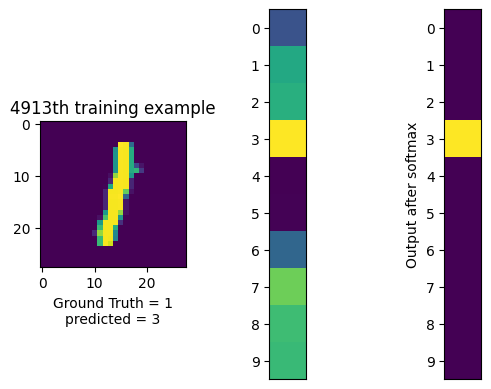

Logits output =  [-14.25135272  19.96671453  22.77655739  59.23129629 -39.6060949
 -39.15973329  -6.93132196  37.55749956  28.409634    27.25636931]
Softmax output =  [1.22149310e-32 8.86357259e-18 1.47200083e-16 1.00000000e+00
 1.18977928e-43 1.85916862e-43 1.84476047e-29 3.86535759e-10
 4.11454808e-14 1.29857086e-14]
Loss value for this example =  -126751.16565380112

======= Epoch : 3 =======
Initial Loss = 61183.27817190578
2000
Loss after training = 51816.08919416098


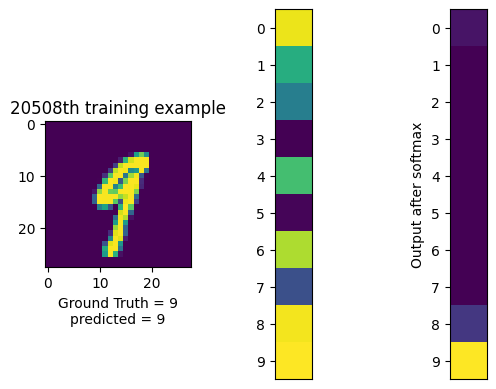

Logits output =  [ 62.4623728   26.80447812   7.0364533  -36.76853574  34.83384288
 -35.26631865  52.91721451 -11.85372456  63.58923021  65.41546945]
Softmax output =  [4.30084870e-02 1.40451786e-17 3.65075904e-26 3.45237650e-45
 4.31157630e-14 1.55068200e-44 3.07712112e-06 2.28288042e-34
 1.32721756e-01 8.24266679e-01]
Loss value for this example =  -105448.45547805358

======= Epoch : 4 =======
Initial Loss = 51816.08919416098
3000
Loss after training = 36587.640571738884

======= Epoch : 5 =======
Initial Loss = 36587.640571738884
4000
Loss after training = 26485.303061441497


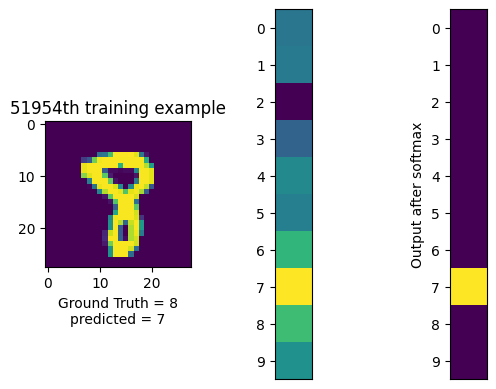

Logits output =  [ 19.91926292  22.17357542 -38.80333229   8.94799293  31.45763961
  25.66059342  59.51173189 110.65554305  64.40405428  36.99664409]
Softmax output =  [3.92404728e-40 3.73912267e-39 1.23263691e-65 6.74484879e-45
 4.02520089e-35 1.22225659e-37 6.14504450e-23 1.00000000e+00
 8.18905240e-21 1.02411008e-32]
Loss value for this example =  -189876.66783466405

======= Epoch : 6 =======
Initial Loss = 26485.303061441497
5000
Loss after training = 23788.34914669497

======= Epoch : 7 =======
Initial Loss = 23788.34914669497
6000
Loss after training = 15068.030111765589

======= Epoch : 8 =======
Initial Loss = 15068.030111765589
7000
Loss after training = 12660.042844270201

======= Epoch : 9 =======
Initial Loss = 12660.042844270201
8000
Loss after training = 11616.856014639146


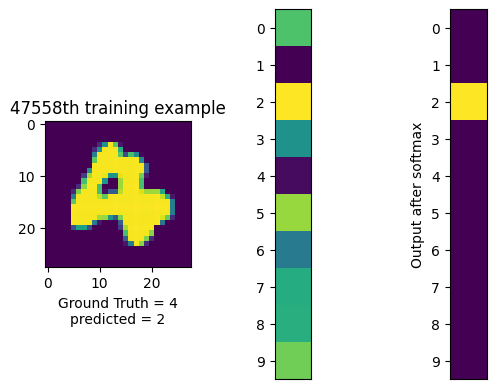

Logits output =  [ 33.12950757 -18.87430804  53.29723318  18.16602261 -16.81392372
  42.16002604  11.09003618  25.89674761  26.54908417  37.61504559]
Softmax output =  [1.74285663e-09 4.53201676e-32 9.99985283e-01 5.52971461e-16
 3.55717349e-31 1.45601552e-05 4.67348502e-19 1.25925570e-12
 2.41779845e-12 1.54634387e-07]
Loss value for this example =  -80830.765955532

======= Epoch : 10 =======
Initial Loss = 11616.856014639146
9000
Loss after training = 9089.187208155456

======= Epoch : 11 =======
Initial Loss = 9089.187208155456
10000
Loss after training = 8656.083702717551

======= Epoch : 12 =======
Initial Loss = 8656.083702717551
11000
Loss after training = 8541.048324826674

======= Epoch : 13 =======
Initial Loss = 8541.048324826674
12000
Loss after training = 9761.931528190868

======= Epoch : 14 =======
Initial Loss = 9761.931528190868
13000
Loss after training = 8716.503904859861

======= Epoch : 15 =======
Initial Loss = 8716.503904859861
14000
Loss after training = 9788.3

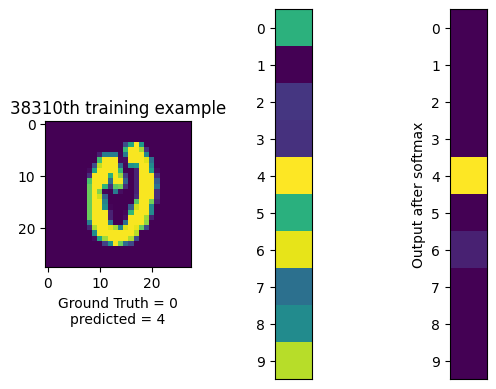

Logits output =  [ 14.79650384 -28.66104842 -17.87936667 -18.94194465  38.87113771
  14.32162984  36.47657894  -3.69269007   3.84463171  31.50541266]
Softmax output =  [3.20891469e-11 4.29519642e-30 2.06732101e-25 7.14391317e-26
 9.15880512e-01 1.99582756e-11 8.35401321e-02 2.99642413e-19
 5.62367924e-16 5.79355414e-04]
Loss value for this example =  0.0

======= Epoch : 16 =======
Initial Loss = 9788.307740002138
15000
Loss after training = 8229.954874486275

======= Epoch : 17 =======
Initial Loss = 8229.954874486275
16000
Loss after training = 7225.202985627878

======= Epoch : 18 =======
Initial Loss = 7225.202985627878
17000
Loss after training = 8316.037208950456

======= Epoch : 19 =======
Initial Loss = 8316.037208950456
18000
Loss after training = 6389.923526037561

======= Epoch : 20 =======
Initial Loss = 6389.923526037561
19000
Loss after training = 6630.204260465611

======= Epoch : 21 =======
Initial Loss = 6630.204260465611
20000
Loss after training = 6547.216242693017



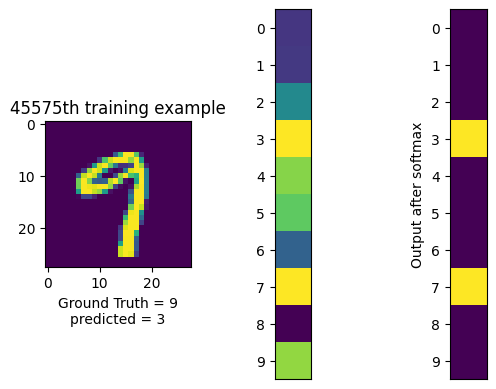

Logits output =  [-0.03906085  0.26130116 12.21660401 33.14883944 25.94691616 23.41162002
  6.02264828 33.14761191 -6.34374179 26.74539016]
Softmax output =  [1.92921366e-15 2.60510894e-15 4.05459933e-10 4.99691876e-01
 3.72346046e-04 2.95040493e-05 8.27841420e-13 4.99078865e-01
 3.52608019e-18 8.27407782e-04]
Loss value for this example =  -45425.25181860566

======= Epoch : 26 =======
Initial Loss = 6258.811403890966
25000
Loss after training = 5471.038558891361

======= Epoch : 27 =======
Initial Loss = 5471.038558891361
26000
Loss after training = 6036.417199014795

======= Epoch : 28 =======
Initial Loss = 6036.417199014795
27000
Loss after training = 6092.312308747639

======= Epoch : 29 =======
Initial Loss = 6092.312308747639
28000
Loss after training = 5110.030986143598

======= Epoch : 30 =======
Initial Loss = 5110.030986143598
29000
Loss after training = 5883.537065298593

======= Epoch : 31 =======
Initial Loss = 5883.537065298593
30000
Loss after training = 5350.558149812

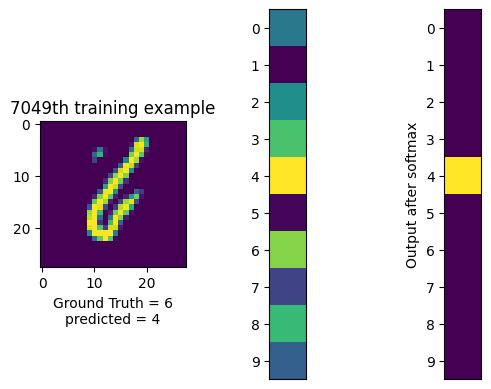

Logits output =  [ -3.46334313 -19.86242965   0.64864307   9.34850102  21.20921984
 -19.1738709   13.80286153 -11.41560508   7.97538211  -7.25659431]
Softmax output =  [1.92563735e-11 1.45392404e-18 1.17594611e-09 7.05809862e-06
 9.99384148e-01 2.89453620e-18 6.07004499e-04 6.77565086e-15
 1.78792689e-06 4.33697029e-13]
Loss value for this example =  -55071.398584312396

======= Epoch : 42 =======
Initial Loss = 3976.1479683685156
41000
Loss after training = 4803.492686032288

======= Epoch : 43 =======
Initial Loss = 4803.492686032288
42000
Loss after training = 4903.372940782998

======= Epoch : 44 =======
Initial Loss = 4903.372940782998
43000
Loss after training = 3895.8393614839897

======= Epoch : 45 =======
Initial Loss = 3895.8393614839897
44000
Loss after training = 4512.962003012303

======= Epoch : 46 =======
Initial Loss = 4512.962003012303
45000
Loss after training = 4431.6847694392045

======= Epoch : 47 =======
Initial Loss = 4431.6847694392045
46000
Loss after training 

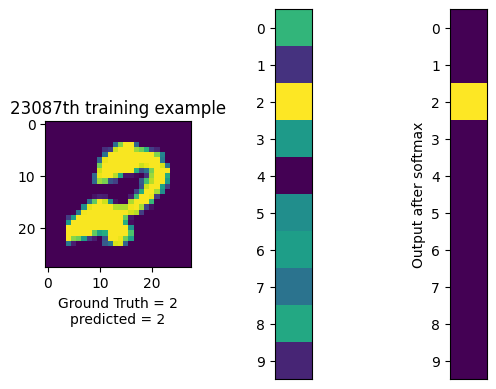

Logits output =  [ 25.64351861  -7.55376437  47.78994266  18.34838421 -17.09700133
  14.91229322  19.28485267   7.53423497  22.01503665 -10.39126913]
Softmax output =  [2.40951835e-10 9.21580815e-25 1.00000000e+00 1.63566222e-13
 6.60629976e-29 5.26524116e-15 4.17250348e-13 3.28979082e-18
 6.39882960e-12 5.39784946e-26]
Loss value for this example =  -90782.95241771569

======= Epoch : 71 =======
Initial Loss = 2585.913218928472
10000
Loss after training = 2430.30071880605

======= Epoch : 72 =======
Initial Loss = 2430.30071880605
11000
Loss after training = 2880.4702843322193

======= Epoch : 73 =======
Initial Loss = 2880.4702843322193
12000
Loss after training = 3493.8474569920977

======= Epoch : 74 =======
Initial Loss = 3493.8474569920977
13000
Loss after training = 3356.715211841389

======= Epoch : 75 =======
Initial Loss = 3356.715211841389
14000
Loss after training = 3476.803735018746

======= Epoch : 76 =======
Initial Loss = 3476.803735018746
15000
Loss after training = 33

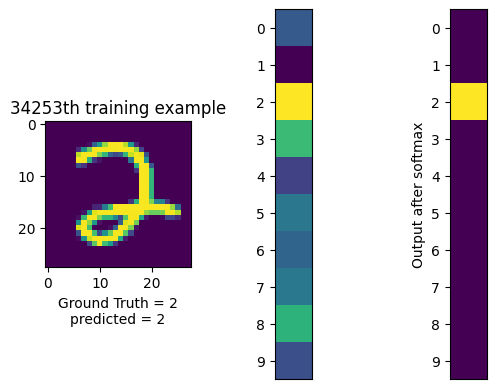

Logits output =  [-13.64939199 -55.26474096  91.53911208  44.60979633 -26.48544699
   2.71478965  -7.85609002   3.67257878  39.41116932 -19.37764664]
Softmax output =  [2.07593199e-46 1.75346339e-64 1.00000000e+00 4.15773809e-21
 5.52821937e-52 2.65513684e-39 6.81102071e-44 6.91909741e-39
 2.29679432e-23 6.75248672e-49]
Loss value for this example =  -217443.55577633553

======= Epoch : 119 =======
Initial Loss = 2262.952002003333
58000
Loss after training = 1498.5385467700894

======= Epoch : 120 =======
Initial Loss = 1498.5385467700894
59000
Loss after training = 1760.8143099135827

======= Epoch : 121 =======
Initial Loss = 1760.8143099135827
0
Loss after training = 2505.4042998959544

======= Epoch : 122 =======
Initial Loss = 2505.4042998959544
1000
Loss after training = 2079.5177222204984

======= Epoch : 123 =======
Initial Loss = 2079.5177222204984
2000
Loss after training = 2132.6679390890463

======= Epoch : 124 =======
Initial Loss = 2132.6679390890463
3000
Loss after train

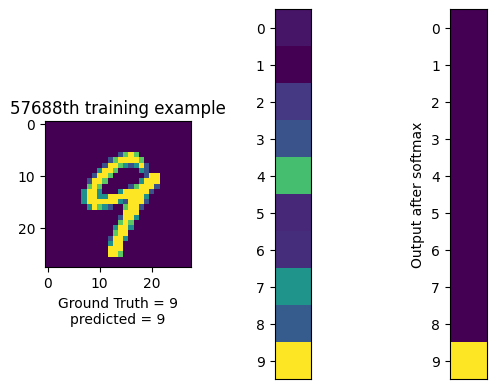

Logits output =  [-2.38718289 -6.05023983  4.90119947 10.66250771 40.22490697  1.59586215
  2.62167573 27.82884912 13.05230789 59.52072377]
Softmax output =  [1.29938471e-27 3.33343765e-29 1.90126211e-24 6.04152213e-22
 4.16805309e-09 6.97512884e-26 1.94561725e-25 1.72343028e-14
 6.59209413e-21 9.99999996e-01]
Loss value for this example =  -109479.44701727461


In [12]:
examples = 10
epochs = 200
last_epoch = -1
learning_rate = 0.01
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch+1} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    correct = 0
    incorrect = 0
    for tx, ty in zip(batchx, batchy):
        _, prediction = MnistClassificationModel.see_dataset_for_training(tx, ty)
        predicted_class = np.argmax(prediction)
        if predicted_class == ty:
            correct += 1
        else:
            incorrect += 1
    accuracy.append((correct)/(correct+incorrect))

    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")
    losses.append(MnistClassificationModel.get_loss())

    log_epoch = np.floor(np.log(epoch + 1)/np.log(epochs)*examples)
    if log_epoch != last_epoch:
        model_tester(print_outputs=True)
    last_epoch = log_epoch


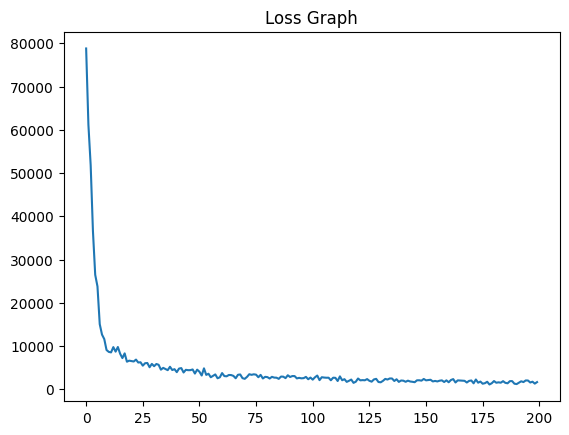

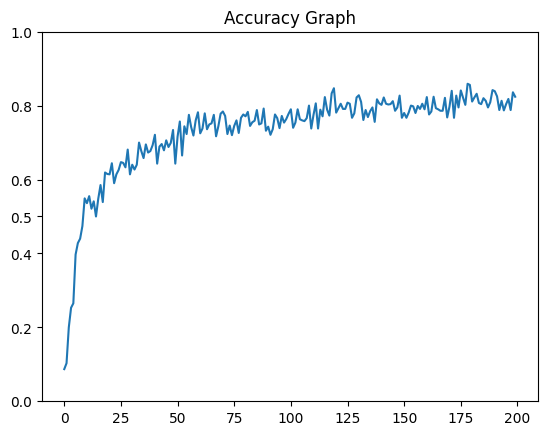

In [13]:
plt.plot(losses)
plt.title("Loss Graph")
plt.savefig("Loss-graph.png")
plt.show()

plt.plot(accuracy)
plt.yticks([0, .2, .4, .5, .6, .8, 1.])
plt.title("Accuracy Graph")
plt.savefig("Accuracy-graph.png")
plt.show()

array([[-18.81324428],
       [ 43.25743182],
       [  4.27547623],
       [ 15.9052936 ],
       [ -7.9837086 ],
       [  4.18063778],
       [ -2.86861111],
       [ 12.54186911],
       [ 19.63859402],
       [  9.83881821]])

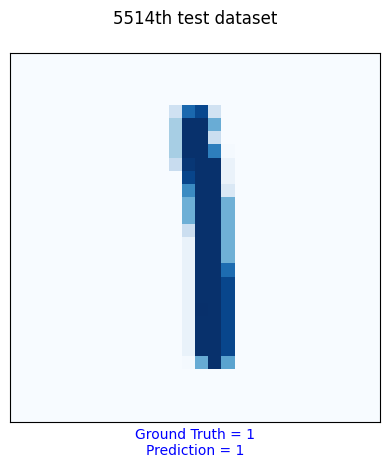

In [14]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number

def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))

choose_random_and_test_model()

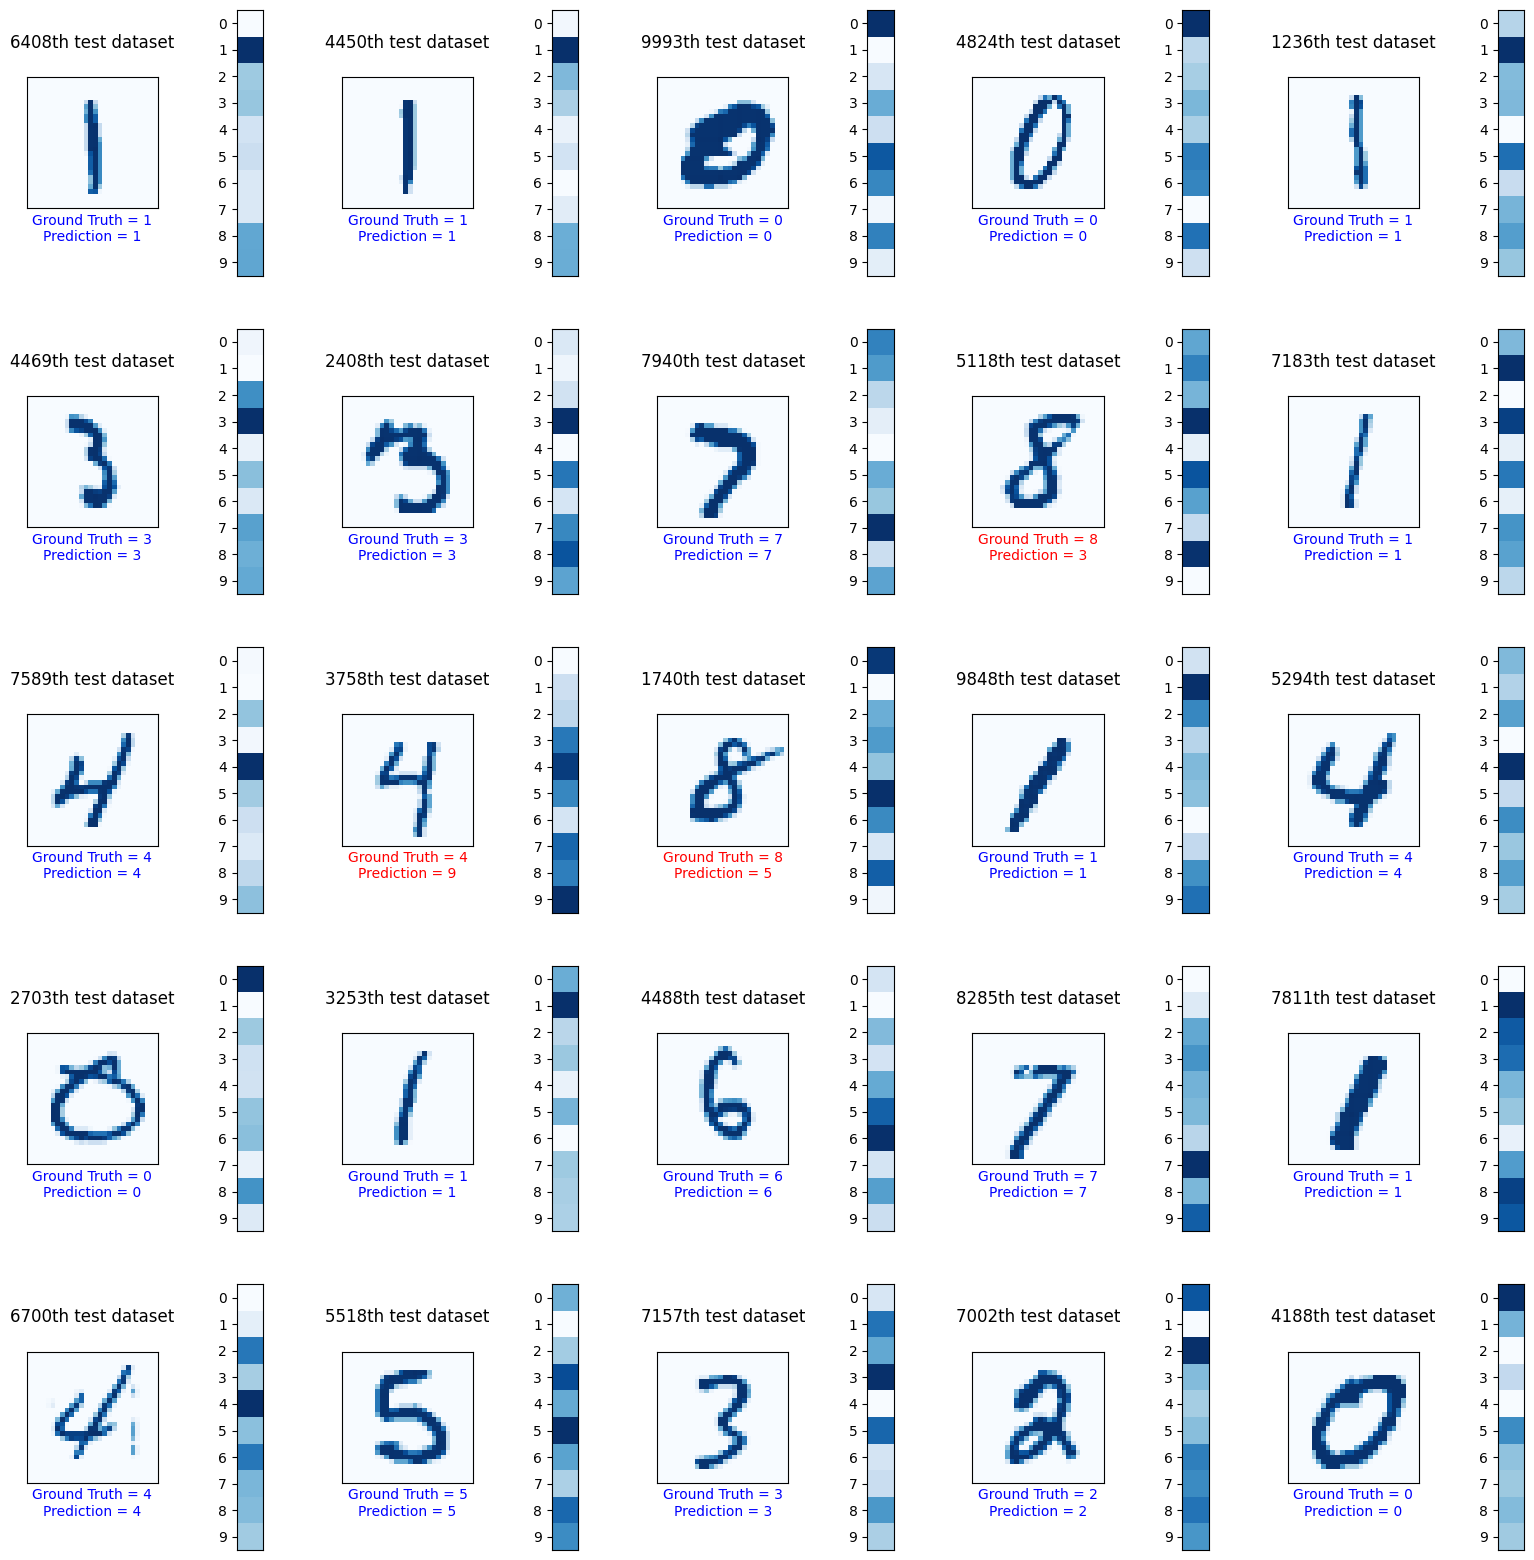

In [15]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
